In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox
from utils.utils import argnotnan, set_spines_visible
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
import trackpy as tp

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
vid_path = "../data/videos/individual-rotifer/2024_07_29/"
vid_filename = "2024_0729_202106_158_trimmed.mp4"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
print(vid_props) # ["filename", "fps", "num_frames", "width", "height"]

pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 1)
img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

# IMAGES
img_filenames = sorted([fn for fn in os.listdir(img_save_dir) if fn.endswith("jpg")])
img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]

# Results
save_path = f"../data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(save_path, exist_ok=True)
SAVE_FIGURES = False

# CREATE! mask filenames based every second image frame exported
#masks_dir = f"../data/seg_masks/{vid_filename.split('.')[0]}_masks/"
#mask_filenames = sorted([fn for fn in os.listdir(masks_dir) if fn.endswith("png")])
#mask_filepaths = [os.path.join(masks_dir, fn) for fn in mask_filenames]

#print(len(mask_filepaths), len(img_filepaths))

(60, 479, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61
Error reading frame at index 472.
Error reading frame at index 473.
Error reading frame at index 474.
Error reading frame at index 475.
Error reading frame at index 476.
Error reading frame at index 477.
Error reading frame at index 478.


# Particle tracking

In [3]:
# Read-in
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))

img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))


real width (µm):  1163.64 
real height (µm): 654.55


In [4]:
from shapely.geometry import Point, Polygon

def is_point_in_polygon(x, y, polygon):
    point = Point(x, y)
    return polygon.contains(point)

n features -  225


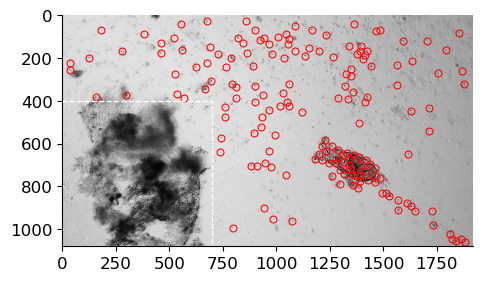

In [6]:
locate_params = {
    "diameter" : 17,
    "threshold" : 17,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# # Rotifer exclude
#rotifer_bbox = [510, img_width, 0, 200]
#rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
#f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = [0, 700, 400, img_height]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# # BBoxes to exclude
#plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)

#ax.set(xlim=(400, img_width), ylim=(0, 300))

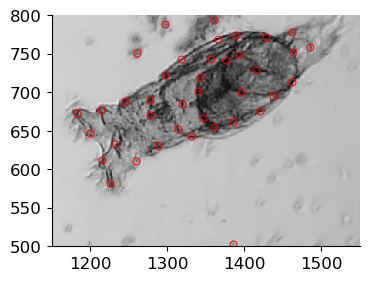

In [ ]:
fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});
ax.set(xlim=(1150, 1550), ylim=(500,800))

mask_polygon = Polygon([(1225, 575), (1170, 675), (1500, 800), (1520, 780)])


In [8]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)

fbatch['inside_mask'] = fbatch.apply(lambda row: is_point_in_polygon(row['x'], row['y'], mask_polygon), axis=1)
fbatch = fbatch[~fbatch['inside_mask']]
fbatch = fbatch.drop(columns=['inside_mask'])

detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]

fbatch

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,23.790123,860.345679,298.463029,1.362641,0.183219,33.531032,-34020.8028,-0.610038,0
1,26.349842,676.595268,1168.059016,2.773238,0.321047,37.952706,-31360.4098,-4.814027,0
2,38.832468,1364.505560,497.069909,1.868946,0.228447,33.899505,-30051.4937,2.013769,0
3,40.288470,554.551368,821.326040,2.118199,0.268915,52.323148,-33627.9887,-0.700341,0
4,46.347607,1086.448992,585.134927,1.761790,0.043790,44.585218,-31073.5204,-18.742206,0
...,...,...,...,...,...,...,...,...,...
93407,880.710856,1574.604801,1022.111520,2.114087,0.179890,56.763628,-29048.3204,0.965725,471
93412,901.308339,1571.696032,1089.129223,2.164471,0.203054,58.228496,-29139.6856,1.013960,471
93414,926.313578,1078.619612,339.849334,1.414214,0.178227,36.987912,-33254.4917,-0.811531,471
93420,987.309333,1770.023111,411.994074,1.561765,0.106285,35.523045,-27445.9765,0.526486,471


In [9]:
link_params = {
    "search_range" : 40,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(20); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 1955
20
N Before: 1955 
 N after filtering: 511


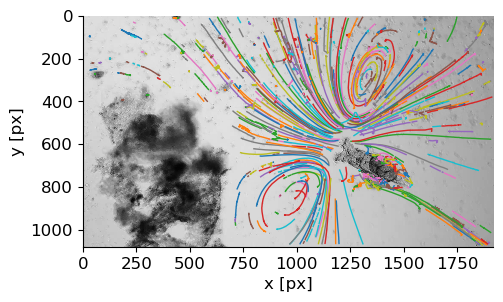

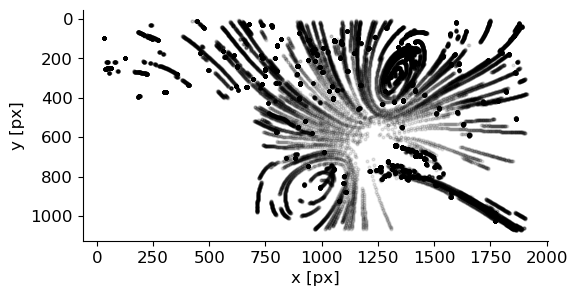

In [10]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax);#, label=True

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"});
#ax.set(**ax_params); ax.invert_yaxis(); ax.invert_xaxis()

# reject based on velocity / acceleration here?!

In [20]:
stats, frames_present = get_trajectory_stats(trajs);

# Re-Calculate stats and reject more based on std of spatial position
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 14) | (stats.y_std < 14)  #reject_idx = (stats.x_std < 20) | (stats.y_std < 20)
reject_prts = stats.particle[reject_idx].to_numpy()  #reject_prts = np.append(reject_prts, [56, 81]) 

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
num_particles_rejected = traj_rejected.particle.nunique()
print("number of particles (original):", num_ori_particles, 
      "\nnumber of rejected particles:", num_particles_rejected, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj)
print(len(stats))
ctraj

number of particles = number of trajectories: 511
number of particles = number of trajectories: 511
number of particles (original): 511 
number of rejected particles: 346 
number of particles remaining: 165
number of particles = number of trajectories: 165
165


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,438.267216,963.580838,492.279762,1.551752,0.092671,44.953691,-34340.2459,-0.552141,0,1
2,476.069759,761.648237,993.034400,2.343111,0.085728,39.795071,-34060.7020,-0.602151,0,6
3,434.279752,1712.271856,653.302409,1.743896,0.144671,52.323148,-27532.6076,0.539970,0,7
7,572.632009,740.803484,1353.769345,2.355457,0.195115,54.902458,-33519.7154,-0.730132,0,12
9,647.511344,1614.321894,1299.235360,2.678352,0.231381,52.691621,-27158.9163,0.487084,0,16
...,...,...,...,...,...,...,...,...,...,...
51145,192.826788,1537.543807,727.306872,2.355598,0.413176,36.987912,-28371.0244,0.713954,471,1300
51148,316.884956,1280.220531,1034.562897,2.503095,0.306332,39.185214,-28968.1954,0.927050,471,132
51152,213.639512,1740.893171,750.744757,1.895823,0.232069,53.833892,-26453.4448,0.410762,471,442
51155,234.950110,1573.358940,829.481402,1.804581,0.185589,60.059581,-27922.9589,0.608931,471,1210


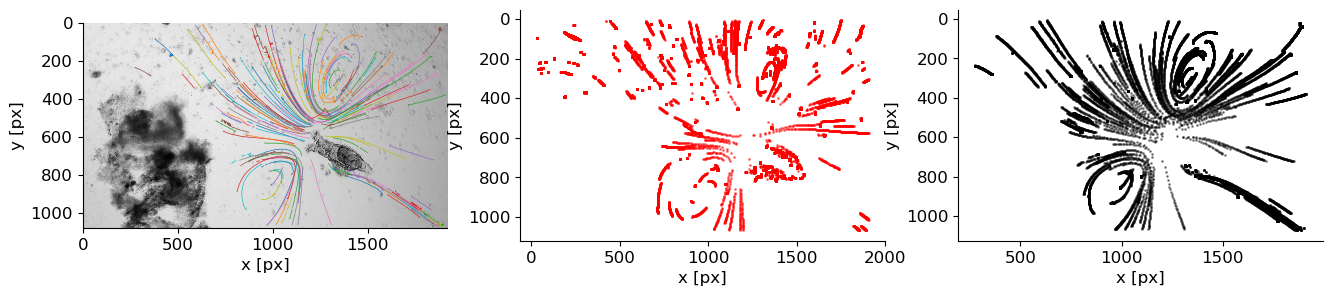

In [12]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
tp.plot_traj(ctraj, superimpose=frames[0], label=False, ax=ax[0], plot_style={"lw" : .5}); #ax[0].set(**ax_params); 
tp.scatter(traj_rejected, ax=ax[1], plot_style={"ms" : 1, "alpha" : .5, "color" : "r", "label" : "rejected"})
tp.scatter(ctraj, ax=ax[2], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});

In [13]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, np.arange(0, len(frames)))
displacement_array = (displacement_array)
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)
df_disp

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.887982,0.378320,1.627992,2.358146,4.087683,3.069530,3.816350,3.023001,1.325571,3.589171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.501762,0.195228,1.520182,2.146107,4.344816,12.491320,3.684726,3.039769,1.406051,4.196011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.681834,0.621925,1.438538,2.336664,3.629095,9.413026,3.616353,3.086115,1.722926,3.642085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.998746,0.059100,1.944976,2.222573,3.905019,1.718129,3.560987,3.185288,1.912009,3.885939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002134,NaN,NaN,0.229791,NaN,0.021536,NaN,NaN,NaN,NaN
469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002134,NaN,NaN,0.070136,NaN,0.142903,NaN,NaN,NaN,NaN
470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.276322,NaN,NaN,0.158862,NaN,0.375669,NaN,NaN,NaN,NaN


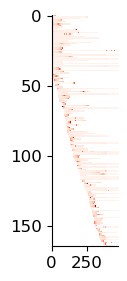

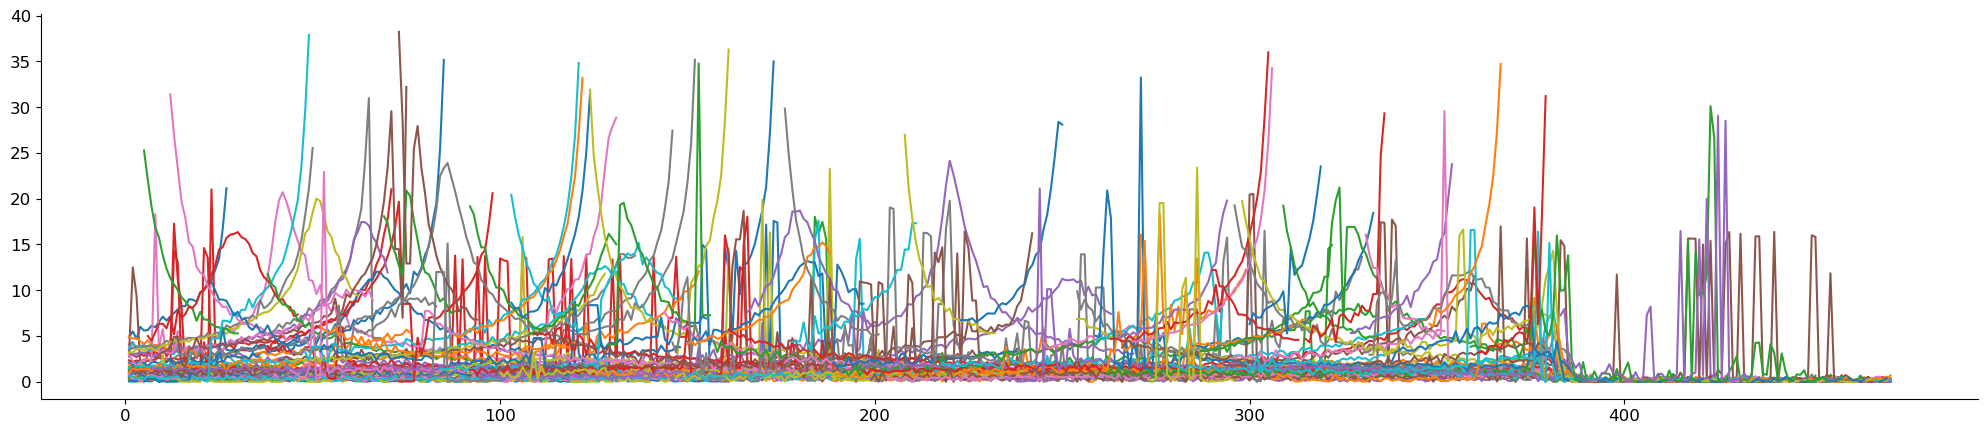

In [14]:
plt.subplots()
plt.imshow(df_disp.values.T, aspect=10, cmap="Reds", interpolation='none', vmin=0, vmax=np.nanmax(df_disp.values))#, extent=[0, fr_time[-1], displacement_array.shape[0], 0]
#displacement_array
plt.subplots(figsize=(25,5))
plt.plot(df_disp.values); # displacement_array.T

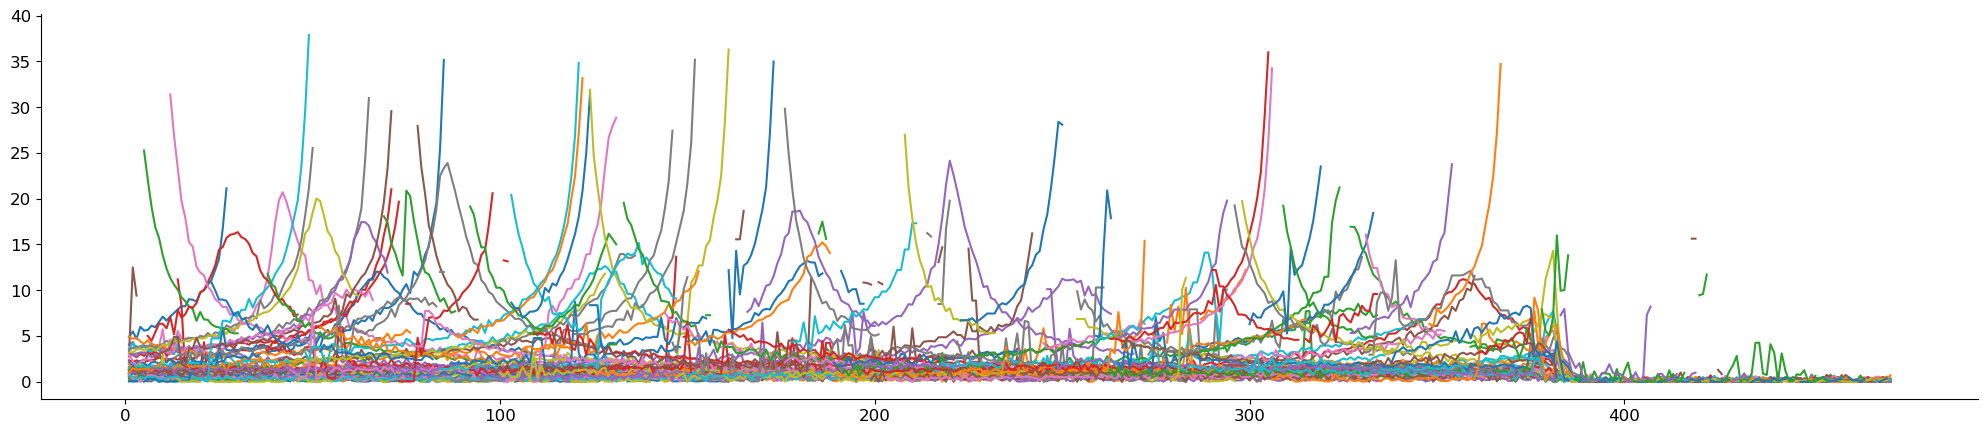

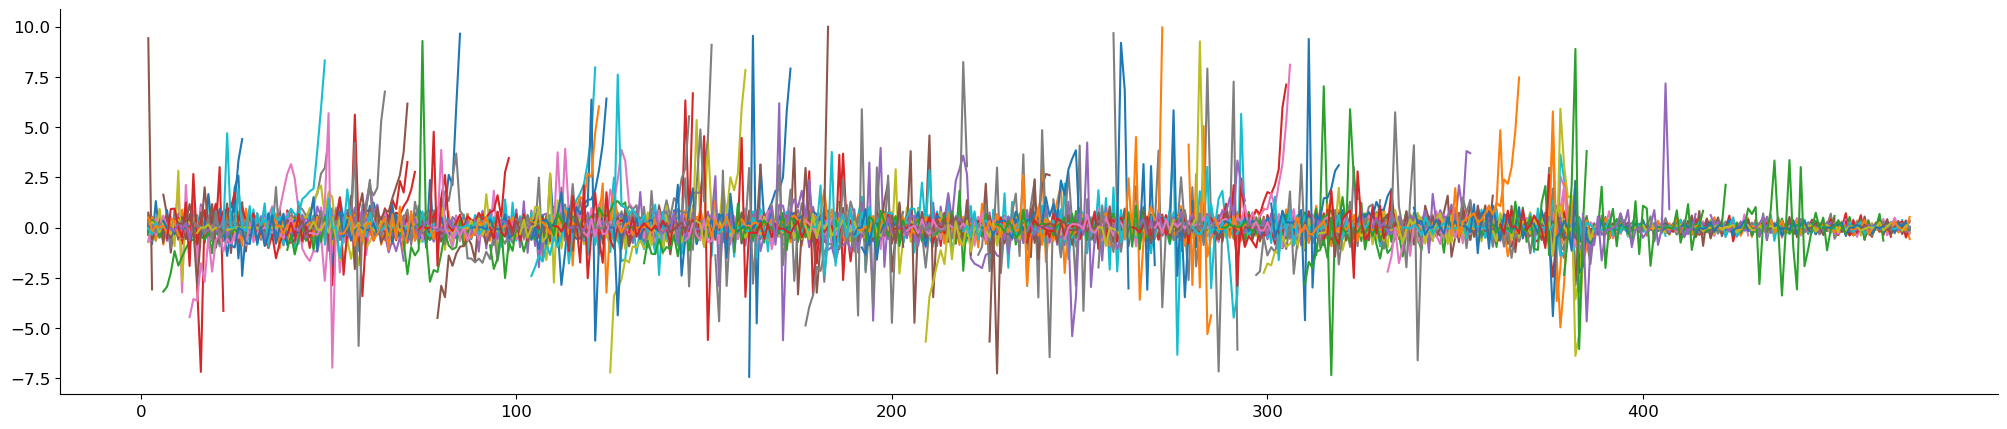

In [18]:
df_masked = df_disp.mask((df_disp.diff()>=10) | (df_disp.diff() *-1 >=7.5))
df_masked

plt.subplots(figsize=(25,5))
plt.plot(df_masked.values); # displacement_array.T

plt.subplots(figsize=(25,5))
plt.plot(df_masked.diff().values);

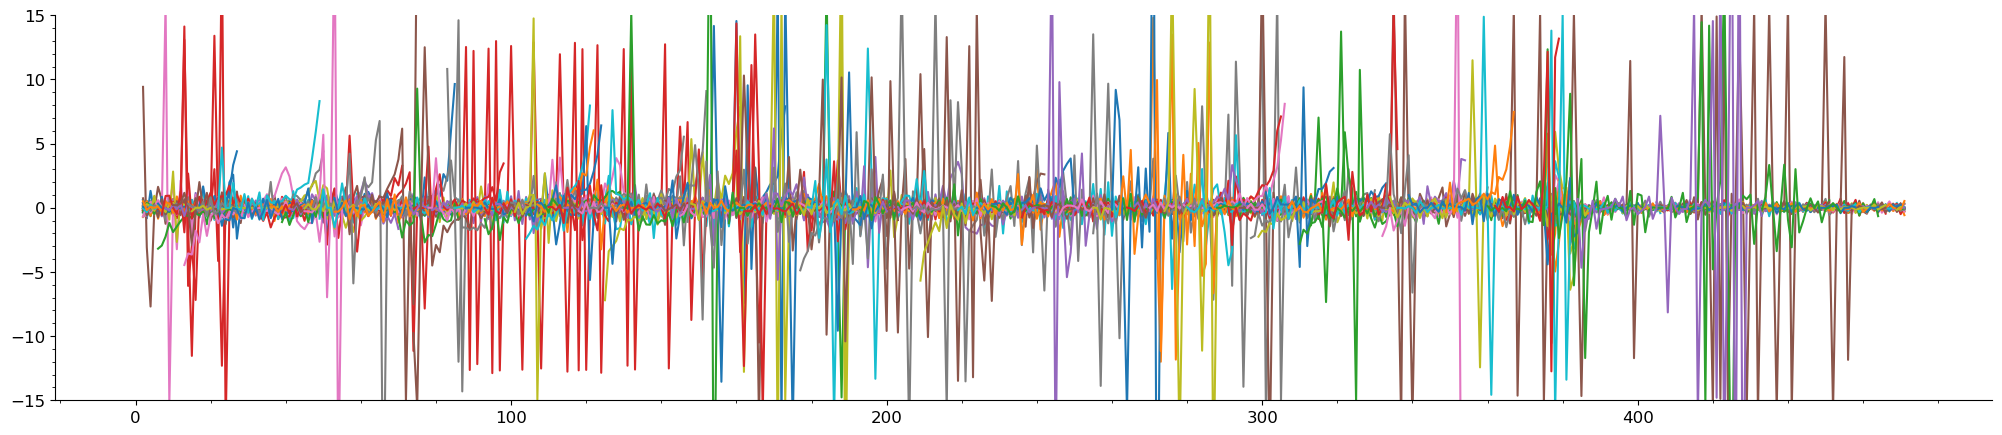

In [16]:
plt.subplots(figsize=(25,5))
plt.plot(df_disp.diff().values);
plt.ylim(-15,15)
plt.minorticks_on()

In [24]:
corona_center = (570, 200)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
ctraj['v'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj["time"] = ctraj["frame"] / fps
ctraj["v"] = ctraj["v"] / mpp * fps
ctraj['v'].max()

1419.5130440461269

380 -- 87.8  ±  96.4 ; dx - 0.3 ; dy - 0.8
381 -- 88.4  ±  109.1 ; dx - 0.4 ; dy - 1.1
382 -- 69.8  ±  74.6 ; dx - 0.1 ; dy - 0.6
383 -- 60.9  ±  72.4 ; dx - 0.2 ; dy - 1.1
384 -- 57.2  ±  111.8 ; dx - -0.0 ; dy - 0.3
385 -- 40.9  ±  82.1 ; dx - 0.3 ; dy - 0.5
386 -- 12.2  ±  19.2 ; dx - 0.1 ; dy - 0.1
387 -- 8.7  ±  10.3 ; dx - 0.0 ; dy - 0.0
388 -- 9.1  ±  12.8 ; dx - 0.0 ; dy - 0.1
395 -- 9.3  ±  8.4 ; dx - 0.0 ; dy - 0.0
38


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_31189/2353522478.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coasting["v"] = coasting["v"].mask(coasting["v"]>550)


13.800904977375565

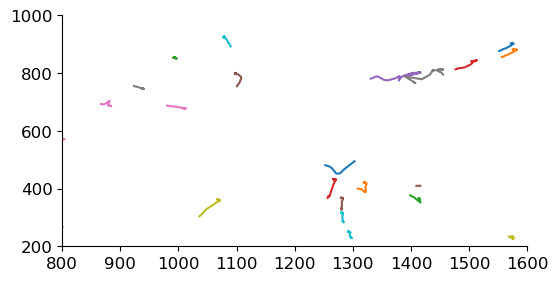

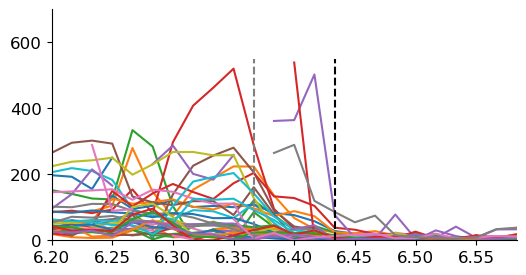

In [53]:
# frame xxx, corona fully closed
retract_start_frame = 382
frames_after = 395
frame_off = 386
frames_before = 372 

# conversion to µm and µm/sec / mpp
coasting = ctraj[ctraj["frame"] >= frames_before]
grouped = coasting.groupby("particle")
prts = coasting["particle"].unique()

fig, ax = plt.subplots()
for prt in prts:
    x, y = grouped.get_group(prt)["x"], grouped.get_group(prt)["y"]
    ax.plot(x,y)
ax.set(xlim=(800, 1600), ylim=(200, 1000))

fig, ax = plt.subplots()
for prt in prts:
    t, v = grouped.get_group(prt)["time"], grouped.get_group(prt)["v"]
    v = v.mask(v>550)
    ax.plot(t, v)

ax.plot([frame_off / fps, frame_off / fps], [0, 550], "--k", label="full-off")
ax.plot([retract_start_frame / fps, retract_start_frame / fps], [0, 550], "--",color="gray", label="soft-off")
ax.set(xlim=(frames_before / fps, frames_after/ fps), ylim=(0, 700))

coasting["v"] = coasting["v"].mask(coasting["v"]>550)
selected_frames = [retract_start_frame-2, retract_start_frame-1, retract_start_frame, retract_start_frame+1, retract_start_frame+2, retract_start_frame+3, frame_off, frame_off+1, frame_off+2, frames_after]
for fr in selected_frames:
    print(fr, "--", round(np.nanmean(coasting.loc[coasting["frame"] == fr, "v"]),1), " ± ", round(np.nanstd(coasting.loc[coasting["frame"] == fr, "v"]),1), 
          "; dx -", round(np.nanmean(coasting.loc[coasting["frame"] == fr, "dx"]) / mpp,1), "; dy -", round(np.nanmean(coasting.loc[coasting["frame"] == fr, "dy"])/ mpp,1))

print(coasting.particle.nunique())
(12.2 / 88.4)  * 100 # 381>386
# 387 no net movement anymore

In [ ]:
ctraj['velocity'] = ctraj['velocity'].mask(ctraj["velocity"]>=30)
ctraj = ctraj.dropna(subset="velocity")

In [ ]:
grouped.get_group(2)

# mask out acceleration values above and bexond
- df_masked = df_disp.mask((df_disp.diff()>=11) | (df_disp.diff() *-1 >=7.5))
- df["v"].diff()!

In [ ]:
grouped = ctraj.groupby("particle")
prts = ctraj["particle"].unique()

fig, ax = plt.subplots()
for prt in prts:
    x, y = grouped.get_group(prt)["x"], grouped.get_group(prt)["y"]
    ax.plot(x,y)

In [ ]:
n_frames = ctraj_.groupby('particle')['frame'].count()
n_frames.sort_values(ascending=False)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')


# Image based capture explore

noteable frames:
start with lower interframe numbers so to check whether it works
- 57-82
- 91-132
- 201-242, handled and rejected, but rotifer movement
- 237-322, multiple catch events, first ones 237-285
- 333-360
- 366-411
- 498-544
- 629-664

In [ ]:
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))

# framew = (57,82)
# pre = np.arange(52,56)
# normed_frame = frames[np.arange(59,61)][ymin:ymax, xmin:xmax] - np.mean(np.stack(frames[pre], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
# print(np.min(normed_frame), np.max(normed_frame), np.percentile(normed_frame, [5, 95]))
# plt.imshow(normed_frame, cmap="gray")

frame_windows = [(57,82), (91,132), (201,242), (237,322), (333,360), (366,411), (498,544), (629,664)];  # cut = 10
stacked_norm = []

for framew in frame_windows:
    n_frames = np.diff(framew)
    window_indices = np.arange(framew[0], framew[1], 1)
    avg_pre = np.mean(np.stack(frames[window_indices[0]-5:window_indices[0]], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
    zprojs = []
    for wi in window_indices:
        
        stacked = np.stack(frames[wi][ymin:ymax, xmin:xmax]) - avg_pre #frames[window_indices[0]][ymin:ymax, xmin:xmax]
        zprojs.append(stacked); #print(stacked.shape)

    stacked = np.stack(zprojs, axis=-1); del zprojs
    norm_stack = np.min(stacked, axis=-1)  # #norm_stack = np.mean(np.diff(stacked, axis=-1), axis=-1)
    stacked_norm.append(norm_stack)
    
    plt.figure(figsize=(10,10))
    plt.imshow(norm_stack, cmap="gray")
    plt.title(f"frames {framew}, n={n_frames}")


plt.figure(figsize=(10,10))
plt.imshow(np.mean(np.stack(stacked_norm, axis=-1) ,axis=-1), cmap="gray")
plt.title(f"frames {framew}, n={n_frames}")


# temporal cut to RGB image

In [ ]:
# cuts = [[38, 41.5], [43.5, 47], [47.75, 51]]
# indices = []
# for cut in cuts:
#     indices.append(df_stats[df_stats["orientation"].between(cut[0], cut[1])].index.values)
#     print(len(indices[-1]))

# ccolor = ["r", "b", "k"]
# fig, ax = plt.subplots(figsize=(3,3))
# for inds, c in zip(indices, ccolor):
#     for nth, ind in enumerate(inds[::2]):
#         rcnt = contour_list[ind]
#         x,y = rcnt.squeeze().T
#         ax.plot(x, y, "-", lw=1, alpha=.4, color=c)

# img_seq_folder = f"{img_save_dir}/*.jpg"
# frames = pims.as_grey(pims.open(img_seq_folder))
# avg = np.mean(frames[1,3,6], axis=-1)

# zprojs = []
# for nth in range(3):
#     stacked = np.stack(frames[indices[nth]]) - frames[indices[nth][0]]
#     print(stacked.shape)
#     zprojs.append(np.min(stacked, axis=0))

# for zproj in zprojs:
#     plt.figure()
#     plt.imshow(zproj, "Reds_r")
    
# norm_zprojs = [1 - (proj - np.min(proj)) / (np.max(proj) - np.min(proj)) for proj in zprojs]

# # RGB stack
# rgb = np.stack(norm_zprojs, axis=-1)
# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.gca().invert_yaxis()

# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.xlim(900,1500); plt.ylim(300, 900)